In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
from sklearn.feature_extraction.text import TfidfVectorizer;

#### Reading the input data

In [2]:
df = pd.read_csv('reuters_data.csv',encoding = "ISO-8859-1")

In [2]:
df = pd.read_csv('data_elonmusk.csv',encoding = "ISO-8859-1")

In [3]:
df.head()

,row ID,Tweet,Time,Retweet from,User
0,Row0,@MeltingIce Assuming max acceleration of 2 to ...,2017-09-29 17:39:19,NaN,elonmusk
1,Row1,RT @SpaceX: BFR is capable of transporting sat...,2017-09-29 10:44:54,SpaceX,elonmusk
2,Row2,@bigajm Yup :),2017-09-29 10:39:57,NaN,elonmusk
3,Row3,Part 2 https://t.co/8Fvu57muhM,2017-09-29 09:56:12,NaN,elonmusk
4,Row4,Fly to most places on Earth in under 30 mins a...,2017-09-29 09:19:21,NaN,elonmusk


In [4]:
df.tail()

,row ID,Tweet,Time,Retweet from,User
3213,Row3213,"@YOUSRC Amos's article was fair, but his edito...",2012-11-20 08:52:03,NaN,elonmusk
3214,Row3214,These articles in Space News describe why Aria...,2012-11-20 08:38:31,NaN,elonmusk
3215,Row3215,Was misquoted by BBC as saying Europe's rocket...,2012-11-20 08:30:44,NaN,elonmusk
3216,Row3216,Just returned from a trip to London and Oxford...,2012-11-19 08:59:46,NaN,elonmusk
3217,Row3217,RT @Jon_Favreau: My Model S just arrived and I...,2012-11-16 17:59:47,Jon_Favreau,elonmusk


In [5]:
df.shape

(3218, 5)

In [7]:
df.columns = ["Index",'Time', 'Tweet']

ValueError: Length mismatch: Expected axis has 5 elements, new values have 3 elements

In [6]:
number_samples, number_columns = df.shape #number of dates by number of columns
number_articles = number_columns-2

#### Group by Year

In [7]:
def get_current_year(date):
    return int(date[:4])

#### Isolating words with spaces and converting to lowercase

In [8]:
for i in range(1):
    col = "Tweet" #"Top" + str(i)
    df[col] = df[col].apply(lambda x:" " if type(x)!=str else x)
    df[col] = df[col].apply(lambda x: re.sub('\W+', ' ', str(x)).lower().strip())

#### Removing stopwords and very small words

In [9]:
stop_words = stopwords.words('english')

for i in range(1):
    col = "Tweet"
    df[col] = df[col].apply(lambda x: ' '.join([w for w in x.split() if (len(w) > 3) and (len(w) <= 11) and w not in ["https","http","yes"] and (w not in stop_words)]))

#### Concatenate all documents in one series

In [10]:
all_columns = []
for i in range(1):
    col = "Tweet"
    all_columns.append(df.iloc[0:1][col])
documents = df.iloc[0:1]['Tweet'].append(all_columns, ignore_index=True)

for row in range(1, number_samples):
    all_columns = []
    for i in range(1):
        col = "Tweet"
        all_columns.append(df.iloc[row:row+1][col])
    documents = documents.append(all_columns, ignore_index=True)

In [11]:
documents = df["Tweet"]

#### Apply vectorizer

In [12]:
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(documents)

In [93]:
type(vectorizer.vocabulary_) #maps terms to indices

dict

In [13]:
documents.shape

(3218,)

#### Function that prints the top words for each topic

In [94]:
def print_top_words(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        topics.append([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    return topics

#### Fit and present topics

In [95]:
num_topics = 5
model = NMF(n_components=num_topics)
nmf = model.fit(X)

tfidf_feature_names = vectorizer.get_feature_names()
topics = print_top_words(nmf, tfidf_feature_names, 10)

Topic #0: spacex launch falcon dragon landing rocket first stage tomorrow live
Topic #1: model tesla teslamotors elonmusk like cars autopilot coming best year
Topic #2: good point chance looks piece rocket right idea pretty people
Topic #3: thanks cool spacex jon_favreau great bill alyssa jovanik21 think juanmlemao
Topic #4: yeah exactly great probably danahull right know read makes love



#### Find the matrix with the topics per document

In [16]:
H = nmf.fit_transform(X)

In [17]:
X.shape

(3218, 7436)

In [18]:
H.sum(axis=0)

array([42.51459772, 75.62126763, 28.32993084, 18.73895926, 23.17410597])

In [19]:
H.mean(axis=0)

array([0.0132115 , 0.02349946, 0.00880358, 0.00582317, 0.0072014 ])

In [20]:
H = H.T

In [81]:
#Now let's sum out those scores over the surrounding 1000 articles scores to see how average scores change over time
topic_number, document_number = H.shape
averages = []
i=0
start = 2012
end = 2017.7
dates = []
while(i < document_number):
    running_sum = H[:, i:i+1]
    i+=1
    count = 0
    while (i)%200 != 0:
        running_sum = running_sum + H[:,i:i+1]
        i+=1
        count+=1
    averages.append(running_sum/count)
    dates.append(start + (end-start) * i/document_number)
averages = np.hstack(average for average in averages)
averages.shape

(5, 16)

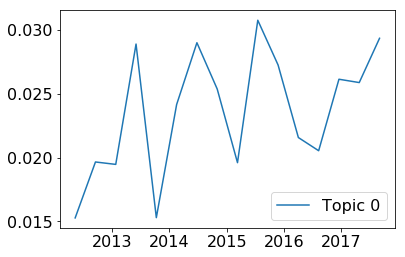

In [82]:
import matplotlib.pyplot as plt
plt.plot(dates[:-1],averages[1,:].T)
plt.legend(["Topic "+str(i) for i in range(averages.shape[0])])

In [32]:
H.shape

(5, 3218)

In [35]:
df.shape

(3218, 7)

In [21]:
from pandas import Series
for i in range(5):
    df['topic '+str(i)] = Series(H[i,:], index=df.index)

In [22]:
df['month'] = Series([(int(x.split('-')[1])-1)//2 for x in df['Time']], index=df.index)
df['year'] = Series([int(x.split('-')[0]) for x in df['Time']], index=df.index)

In [23]:
df.head()

,row ID,Tweet,Time,Retweet from,User,topic 0,topic 1,topic 2,topic 3,topic 4,month,year
0,Row0,meltingice assuming comfortable direction feel...,2017-09-29 17:39:19,NaN,elonmusk,0.000978,0.012316,0.005001,0.000544,0.000127,4,2017
1,Row1,spacex capable satellites orbit crew cargo com...,2017-09-29 10:44:54,SpaceX,elonmusk,0.071444,0.000000,0.005397,0.003489,0.000000,4,2017
2,Row2,bigajm,2017-09-29 10:39:57,NaN,elonmusk,0.000000,0.000000,0.000000,0.000000,0.000000,4,2017
3,Row3,part 8fvu57muhm,2017-09-29 09:56:12,NaN,elonmusk,0.000000,0.012460,0.000000,0.001610,0.000000,4,2017
4,Row4,places earth mins anywhere cost seat dgyddgttyd,2017-09-29 09:19:21,NaN,elonmusk,0.007300,0.005630,0.000872,0.000000,0.000000,4,2017


In [24]:
averages1 = df.groupby(["year","month"])['topic 1'].mean().reset_index()["topic 1"].tolist()
averages0 = df.groupby(["year","month"])['topic 0'].mean().reset_index()["topic 0"].tolist()
sums1 = df.groupby(["year","month"])['topic 1'].sum().reset_index()["topic 1"].tolist()
sums0 = df.groupby(["year","month"])['topic 0'].sum().reset_index()["topic 0"].tolist()

In [25]:
df.groupby(["year","month"])['topic 1'].mean().reset_index()["topic 1"]

0     0.022229
1     0.040527
2     0.025226
3     0.026662
4     0.024768
5     0.017858
6     0.028975
7     0.037938
8     0.022311
9     0.018073
10    0.025538
11    0.024019
12    0.032058
13    0.011944
14    0.022189
15    0.017430
16    0.035377
17    0.035433
18    0.015002
19    0.025150
20    0.026664
21    0.020377
22    0.026229
23    0.028365
24    0.029309
25    0.015533
26    0.030636
27    0.016988
28    0.020209
29    0.013921
Name: topic 1, dtype: float64

In [27]:
topic1 = df.groupby(["year","month"])['topic 1'].sum().reset_index()
topic0 = df.groupby(["year","month"])['topic 0'].sum().reset_index()

In [150]:
averages0[0:4]

[0.4567258247984701,
 0.42335817420252525,
 1.6620377061673923,
 0.9012113838516999]

In [158]:
len(averages1)

30

In [28]:
dates = []
for i in range(len(topic1)):
    dates.append(int(topic1.iloc[i,0])+int(topic1.iloc[i,1])/6)

In [29]:
dates[0]

2012.8333333333333

Text(0,0.5,'Relevance of topic')

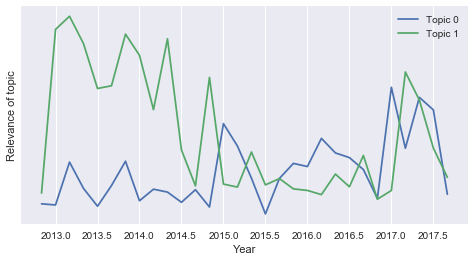

In [90]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

plt.figure(figsize=(8,4))
dates.reverse()
plt.plot(dates,sums0)

plt.plot(dates,sums1)
plt.legend(["Topic 0","Topic 1"])
plt.yticks([])
plt.xticks([2013+i/2 for i in range(10)])
plt.xlabel('Year')
plt.ylabel('Relevance of topic')

In [238]:
averages

[1295958.9743589743,
 2542900.0,
 10483948.717948718,
 9760184.615384616,
 10657335.897435898,
 13444900.0,
 9937248.717948718,
 9797733.333333334,
 8106730.769230769,
 5783600.0,
 5546525.641025641,
 6457823.076923077,
 5845466.666666667,
 5210556.41025641,
 5259579.487179487,
 3794807.6923076925,
 4479641.025641026,
 4642789.743589744,
 3645420.512820513,
 4887646.153846154,
 6037212.820512821,
 4545707.692307692,
 4838856.41025641,
 3069423.076923077,
 4651546.153846154,
 4724128.205128205,
 5522305.128205128,
 6370917.948717949,
 9129964.102564102,
 5972271.794871795,
 6953977.777777778]

In [109]:
df.tail()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
1984,2016-06-27,0,barclays rbs shares suspended trading tanking,pope says church ask forgiveness gays past tre...,poland shocked xenophobic abuse poles,second referendum cabinet agrees,scotland welcome join merkel ally says,sterling dips friday year low amid brexit unce...,negative news south african president allowed ...,surge hate crimes following brexit vote,...,german lawyers probe erdogan alleged war crimes,boris johnson says continue intensify cooperat...,richard branson calling government hold second...,turkey sorry downing russian jet,edward snowden lawyer vows new push pardon obama,brexit opinion poll reveals majority want seco...,conservative leave campaigner leave campaign p...,economists predict recession weakening pound f...,new superstate plan france germany creating eu...,pakistani clerics declare transgender marriage...
1985,2016-06-28,1,500 scientists australia want save great barri...,personal details 112 000 french police officer...,amp cuts united kingdom sovereign credit ratin...,huge helium deposit found africa,ceo south african state broadcaster quits shor...,brexit cost investors trillion worst one day d...,hong kong democracy activists call return brit...,brexit iceland president says join triangle no...,...,canada mexico pledge power clean energy 2025,increasing evidence australia torturing refuge...,richard branson founder virgin group said tues...,000 old skull borneo reveals surprise scientis...,palestinians stone western wall worshipers pol...,jean claude juncker asks farage,romanians remainians offering new home britons...,brexit gibraltar talks scotland stay,suicide bombers strike lebanon,mexico security forces routinely use sexual to...
1986,2016-06-29,1,explosion airport istanbul,yemeni former president terrorism offspring wa...,must accept freedom movement access market,devastated scientists late captive breed mamma...,british labor party leader jeremy corbyn loses...,muslim shop firebombed people inside,mexican authorities sexually torture women prison,shares pound continue recover,...,escape tunnel dug hand found holocaust massacr...,land beijing sinking much four inches per year...,car bomb anti islamic attack mosque perth aust...,emaciated lions taiz zoo trapped blood soaked ...,rupert murdoch describes brexit wonderful medi...,killed yemen suicide attacks,google found disastrous symantec norton vulner...,extremist violence rise germany domestic intel...,bbc news labour mps pass corbyn confidence motion,tiny new zealand town many jobs launches drive...
1987,2016-06-30,1,jamaica proposes marijuana dispensers tourists...,stephen hawking says pollution stupidity still...,boris johnson says run tory party leadership,six gay men ivory coast abused forced flee hom...,switzerland denies citizenship muslim immigran...,palestinian terrorist stabs israeli teen girl ...,puerto rico default billion debt friday,republic ireland fans awarded medal sportsmans...,...,googles free wifi indian railway stations bett...,mounting evidence suggests hobbits wiped moder...,men carried tuesday terror attack istanbul ata...,calls suspend saudi arabia human rights counci...,100 nobel laureates call greenpeace anti gmo o...,british pedophile sentenced years trafficking ...,permitted 200 offshore fracks gulf mexico 2010...,swimming ridicule french beach police carry gu...,uefa says minutes silence istanbul victims eur...,law enforcement sources gun used paris terrori...
1988,2016-07-01,1,117 year old woman mexico city finally receive...,imf chief backs athens permanent olympic host,president france says brexit donald trump,british man must give police hours notice sex ...,100 nobel laureates urge greenpeace stop oppos...,brazil huge spike number police killings rio a...,austria highest court annuls presidential elec...,facebook wins privacy case track belgian wants...,...,united states placed myanmar uz

In [32]:
df2 = pd.read_csv('TSLA.csv',encoding = "ISO-8859-1")

In [33]:
df2.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-12-11,34.599998,35.500000,34.459999,35.279999,35.279999,1572600
1,2012-12-12,35.209999,35.799999,34.950001,35.259998,35.259998,2063800
2,2012-12-13,35.259998,35.299999,32.750000,33.610001,33.610001,2151300
3,2012-12-14,33.779999,34.400002,33.590000,33.810001,33.810001,1023000
4,2012-12-17,33.770000,34.500000,33.750000,34.400002,34.400002,824900


In [34]:
df2.shape

(1210, 7)

In [35]:
df2.iloc[0,6]

1572600

In [36]:
1210//40

30

In [75]:
#Now let's sum out those scores over the surrounding 1000 articles scores to see how average scores change over time
document_number, topic_number = df2.shape
stock_averages = []
vol_averages = []
i=0
start = 2012.83
end = 2017.66
dates_stock = []
while(i < document_number):
    running_sum = df2.iloc[i,4]
    running_sum_vol = df2.iloc[i,6]
    i+=1
    count = 0
    while (i)%(1210//29) != 0 and i < document_number:
        #print(i)
        running_sum = running_sum + df2.iloc[i,4]
        running_sum_vol += df2.iloc[i,6]
        i+=1
        count+=1
    stock_averages.append(running_sum/count)
    vol_averages.append(running_sum_vol/count)
    dates_stock.append(start + (end-start) * i/document_number)
#averages = np.hstack(average for average in averages)
#averages.shape

In [76]:
len(dates_stock)

30

In [183]:
len(averages)

31

In [211]:
stock_averages[:3]

[36.16461535897436, 38.78410264102564, 70.27717930769232]

In [167]:
len(dates)

30

Text(0,0.5,'Relevance of topic')

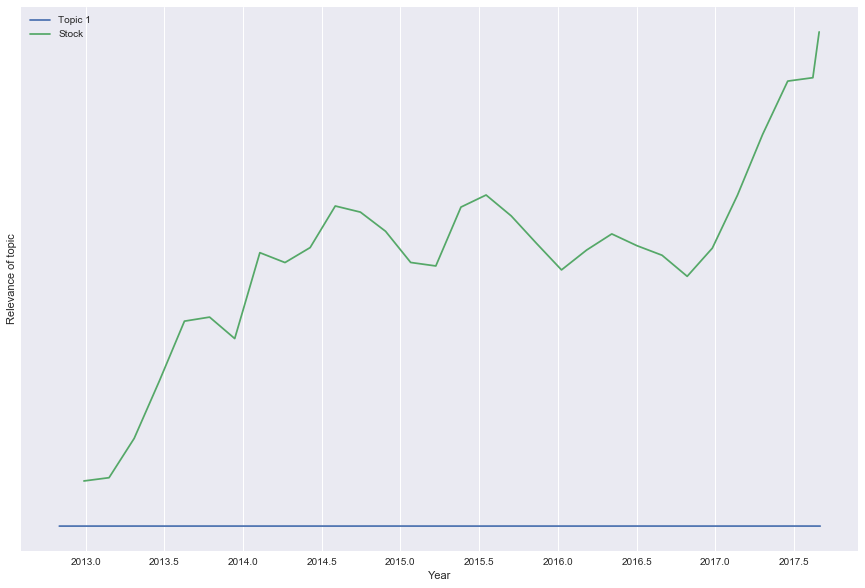

In [51]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

plt.figure(figsize=(15,10))
#plt.plot(dates,averages0)
dates.reverse()
plt.plot(dates,averages1)
plt.plot(dates_stock,stock_averages)
plt.legend(["Topic 1","Stock"])#,"Topic 1"])
plt.yticks([])
plt.xticks([2013+i/2 for i in range(10)])
plt.xlabel('Year')
plt.ylabel('Relevance of topic')

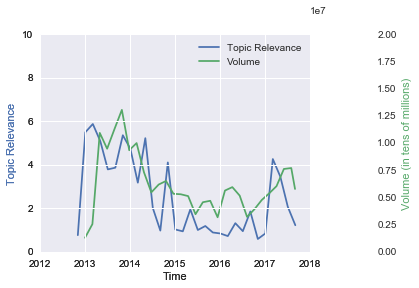

In [85]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()
offset = 60
new_fixed_axis = par1.get_grid_helper().new_fixed_axis
par1.axis["right"] = new_fixed_axis(loc="right", axes=par1,
                                        offset=(offset, 0))

#par2.axis["right"].toggle(all=True)

host.set_xlim(2012, 2018)
host.set_ylim(-0.0, 10)

host.set_xlabel("Time")
host.set_ylabel("Topic Relevance")
par1.set_ylabel("Volume (in tens of millions)")
#par2.set_ylabel("Stock Close")

p1, = host.plot(dates,sums1, label="Topic Relevance")
p2, = par1.plot(dates_stock, vol_averages, label="Volume")
#p3, = par2.plot([0, 1, 2], [50, 30, 15], label="Velocity")

par1.set_ylim(0, 20000000)
#par2.set_ylim(1, 65)

host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p2.get_color())

plt.draw()
plt.show()

#plt.savefig("Test")

In [50]:
import seaborn as sns
sns.set()

In [66]:
len(sums1)

30

In [71]:
dates_stock[0:3]

[2012.9896694214876, 2013.149338842975, 2013.3090082644628]

In [72]:
dates[0:3]

[2012.8333333333333, 2013.0, 2013.1666666666667]

In [77]:
import sklearn
sklearn.metrics.matthews_corrcoef(sums1,vol_averages)

ValueError: continuous is not supported

In [87]:
import scipy
averages1.reverse()
scipy.stats.pearsonr(averages1,vol_averages)

(0.07327774462395595, 0.700368976918874)